Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_4 (Bat  (None, 256,

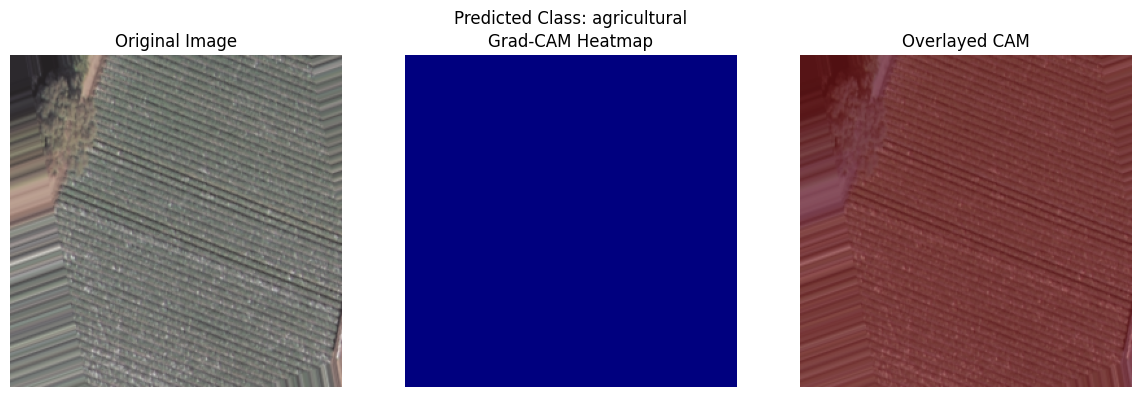

1/1 [==============================] - 0s 175ms/step


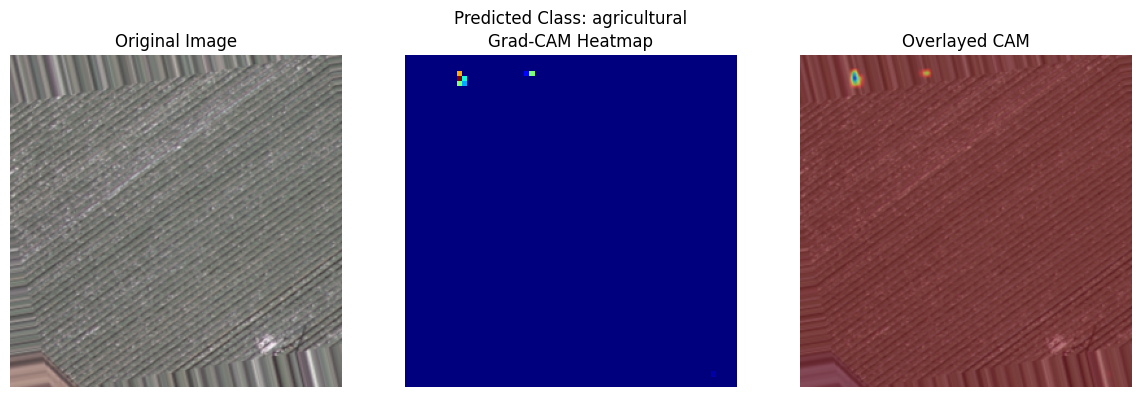

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2

# -------------------------------
# Configuration
# -------------------------------
DATA_PATH = 'data'  # expects data/<class_name>/*.tif or *.jpg etc.
IMG_SIZE = (256, 256)   # UC Merced images are 256x256
BATCH_SIZE = 32
NUM_EPOCHS = 100  # Increased epochs for more training opportunities
LEARNING_RATE = 1e-3
NUM_CLASSES = 21  # Number of categories in UC Merced

# -------------------------------
# Data Loading & Augmentation
# -------------------------------
# Enhance augmentation with additional shifts
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# -------------------------------
# Build an Enhanced CNN Model
# -------------------------------
def build_cnn(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    
    # Block 1
    x = layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 3
    x = layers.Conv2D(128, (3,3), padding='same', name='last_conv')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Global Average Pooling to maintain spatial information for CAM
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense block with dropout for further regularization
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_cnn(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# -------------------------------
# Training the Enhanced CNN
# -------------------------------
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('cnn_ucmerced_best.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# -------------------------------
# Evaluate the Model on Validation Data
# -------------------------------
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")

# -------------------------------
# Grad-CAM Implementation for CAM Visualization
# -------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image.
    
    Args:
        img_array: Preprocessed image array of shape (1, H, W, 3)
        model: Trained CNN model.
        last_conv_layer_name: Name of the last conv layer.
        pred_index: Class index for which to compute Grad-CAM. If None, use the predicted class.
    Returns:
        heatmap: Grad-CAM heatmap (H, W)
    """
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4, colormap=plt.cm.jet):
    """
    Overlays the heatmap on the image.
    
    Args:
        img: Original image array (H, W, 3) in [0,1] range.
        heatmap: Heatmap of shape (H, W) normalized between 0 and 1.
        alpha: Intensity factor for heatmap overlay.
        colormap: Colormap for the heatmap.
    Returns:
        overlayed_img: Image with heatmap overlay.
    """
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), (img.shape[0], img.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = colormap(heatmap)
    heatmap = np.uint8(255 * heatmap[..., :3])
    
    img_uint8 = np.uint8(255 * img)
    overlayed_img = cv2.addWeighted(img_uint8, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img

# -------------------------------
# Visualizing CAM on Sample Test Images
# -------------------------------
val_imgs, val_labels = next(val_generator)

for i in range(2):
    img = val_imgs[i]
    img_array = np.expand_dims(img, axis=0)
    
    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='last_conv', pred_index=pred_class)
    cam_image = overlay_heatmap(img, heatmap, alpha=0.5)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
    plt.title("Overlayed CAM")
    plt.axis('off')
    
    class_names = list(train_generator.class_indices.keys())
    plt.suptitle(f"Predicted Class: {class_names[pred_class]}")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Save the Trained Model
# -------------------------------
model.save("cnn_ucmerced_model_enhanced.h5")


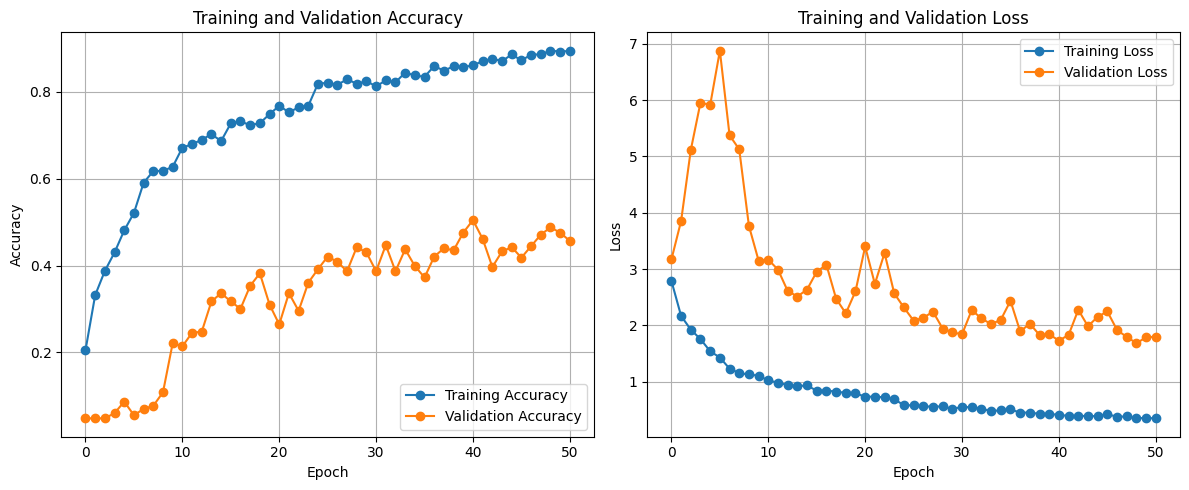

In [15]:
# -------------------------------
# Plot Training & Validation Accuracy and Loss
# -------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
